<h1 align="center">Focused Ion Beam Scanning Electron Microscopy Image Segmentation</h1>


**Summary:**
1. SimpleITK supports a large number of filters that facilitate classical segmentation algorithms (variety of thresholding algorithms, watersheds...).
2. Once your data is segmented SimpleITK enables you to efficiently post process the segmentation (e.g. label distinct objects, analyze object shapes).

This notebook will illustrate the use of SimpleITK for segmentation of bacteria from a 3D Focused Ion Beam Scanning Electron Microscopy (FIB-SEM) image. The specific bacterium is <a href="https://en.wikipedia.org/wiki/Bacillus_subtilis">bacillus subtilis</a>, a rod shaped organism naturally found in soil and plants. The bacteria have been subjected to stress to initiate the process of forming an endospore. These endospores can be seen as a generally dark ellipsoid inside the individual bacterium.

In [4]:
import SimpleITK as sitk
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
import gui
from math import ceil
from downloaddata import fetch_data as fdata

# Load data

Load the 3D volume and display it.

Fetching fib_sem_bacillus_subtilis.mha


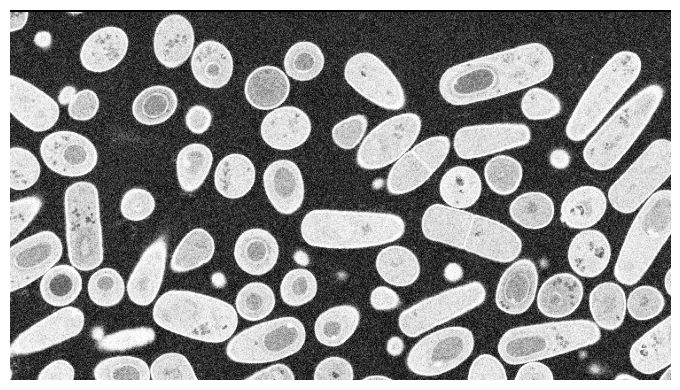

In [5]:
img = sitk.ReadImage(fdata("fib_sem_bacillus_subtilis.mha"))
gui.MultiImageDisplay(image_list=[img], figure_size=(8, 4));

# Segmentation

To allow us to analyze the shape of whole bacteria we first need to segment them. We will do this in several steps:
1. Separate the bacteria from the embedding resin background.
2. Mark each potential bacterium with a unique label, to evaluate the segmentation.
3. Remove small components and fill small holes using binary morphology operators (opening and closing).
4. Use seed based watersheds to perform final segmentation.
5. Remove bacterium that are connected to the image boundary.

## Separate the bacteria from the background

Based on the visualization of the data above, it intuitively appears that the background and foreground are separable using a single intensity threshold. Our first step towards validating this observation is to plot the intensity distribution.

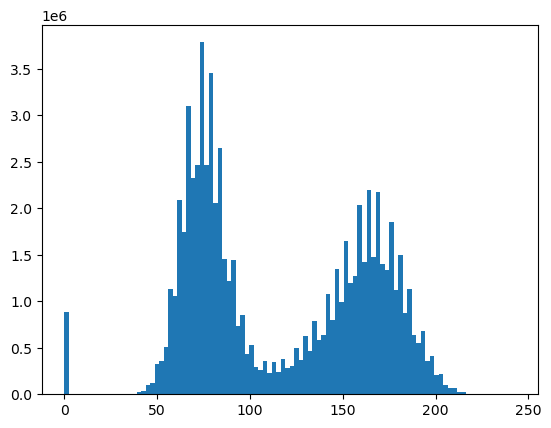

In [6]:
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(img).flatten(), bins=100)
plt.show()

The histogram is bi-modal with a clear separation, which we have manually identified as having an intensity value of 120.

We can also use one of several binary threshold selection filters available in SimpleITK. 

Threshold used: 120


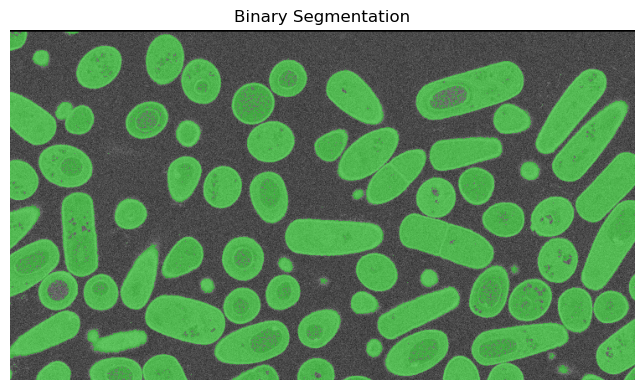

In [8]:
threshold_filters = {
    "Otsu": sitk.OtsuThresholdImageFilter(),
    "Triangle": sitk.TriangleThresholdImageFilter(),
    "Huang": sitk.HuangThresholdImageFilter(),
    "MaxEntropy": sitk.MaximumEntropyThresholdImageFilter(),
}

filter_selection = "Manual"
try:
    thresh_filter = threshold_filters[filter_selection]
    thresh_filter.SetInsideValue(0)
    thresh_filter.SetOutsideValue(1)
    thresh_img = thresh_filter.Execute(img)
    thresh_value = thresh_filter.GetThreshold()
except KeyError:
    thresh_value = 120
    thresh_img = img > thresh_value

print("Threshold used: " + str(thresh_value))
gui.MultiImageDisplay(
    image_list=[sitk.LabelOverlay(img, thresh_img)],
    title_list=["Binary Segmentation"],
    figure_size=(8, 4),
);

# Mark each potential bacterium with unique label and evaluate

In [ ]:
stats = sitk.LabelShapeStatisticsImageFilter()
stats.Execute(sitk.ConnectedComponent(thresh_img))

# Look at the distribution of sizes of connected components (bacteria).
label_sizes = [stats.GetNumberOfPixels(l) for l in stats.GetLabels() if l != 1]

plt.figure()
plt.hist(label_sizes, bins=200)
plt.title("Distribution of Object Sizes")
plt.xlabel("size in pixels")
plt.ylabel("number of objects")
plt.show()

The histogram above shows tens of thousands of very small labels which are not visually detected by looking at the segmentation.

## Remove small islands and holes

Using binary morphological operations we remove small objects using the opening operation and fill small holes using the closing operation. The use of opening and closing by reconstruction maintains the boundary of the original objects.

In [ ]:
cleaned_thresh_img = sitk.BinaryOpeningByReconstruction(thresh_img, [10, 10, 10])
cleaned_thresh_img = sitk.BinaryClosingByReconstruction(
    cleaned_thresh_img, [10, 10, 10]
)

gui.MultiImageDisplay(
    image_list=[sitk.LabelOverlay(img, cleaned_thresh_img)],
    title_list=["Cleaned Binary Segmentation"],
    figure_size=(8, 4),
);

Check that the number of objects defined by the binary image is more reasonable.

In [ ]:
stats = sitk.LabelShapeStatisticsImageFilter()
stats.Execute(sitk.ConnectedComponent(cleaned_thresh_img))

# Look at the distribution of sizes of connected components (bacteria).
label_sizes = [stats.GetNumberOfPixels(l) for l in stats.GetLabels() if l != 1]

plt.figure()
plt.hist(label_sizes, bins=200)
plt.title("Distribution of Object Sizes")
plt.xlabel("size in pixels")
plt.ylabel("number of objects")
plt.show()

After the morphological operations, our binary image seems to have a reasonable number of objects, but is this true? We next look at the unique objects defined by this binary segmentation (each object is marked with a unique color).

In [ ]:
gui.MultiImageDisplay(
    image_list=[sitk.LabelOverlay(img, sitk.ConnectedComponent(cleaned_thresh_img))],
    title_list=["Cleaned Binary Segmentation"],
    figure_size=(8, 4),
);

## Seed based watershed segmentation

The bacteria appear to be segmented correctly from the background but not from each other. Using the visualization and histogram above we see that in 3D many of them are connected, even if on a slice by slice inspection they appear separate.  

In [ ]:
dist_img = sitk.SignedMaurerDistanceMap(
    cleaned_thresh_img != 0,
    insideIsPositive=False,
    squaredDistance=False,
    useImageSpacing=False,
)
radius = 10
# Seeds have a distance of "radius" or more to the object boundary, they are uniquely labelled.
seeds = sitk.ConnectedComponent(dist_img < -radius)
# Relabel the seed objects using consecutive object labels while removing all objects with less than 15 pixels.
seeds = sitk.RelabelComponent(seeds, minimumObjectSize=15)
# Run the watershed segmentation using the distance map and seeds.
ws = sitk.MorphologicalWatershedFromMarkers(dist_img, seeds, markWatershedLine=True)
ws = sitk.Mask(ws, sitk.Cast(cleaned_thresh_img, sitk.sitkUInt8))

Visualize the distance map, the unique seeds and final object segmentation.

In [ ]:
gui.MultiImageDisplay(
    image_list=[dist_img, sitk.LabelOverlay(img, seeds), sitk.LabelOverlay(img, ws)],
    title_list=[
        "Segmentation Distance",
        "Watershed Seeds",
        "Binary Watershed Labeling",
    ],
    shared_slider=True,
    horizontal=False,
    figure_size=(6, 12),
);

## Removal of objects touching the image boundary

We are not sure objects touching the image boundary are whole bacteria, so we remove them.

In [ ]:
# The image has a small black border which we account for here.
bgp = sitk.BinaryGrindPeak((ws != 0) | (img == 0))
non_border_seg = sitk.Mask(ws, bgp == 0)
gui.MultiImageDisplay(
    image_list=[sitk.LabelOverlay(img, non_border_seg)],
    title_list=["Final Segmentation"],
    figure_size=(8, 4),
);

# Object Analysis

Once we have the segmented objects we look at their shapes and the intensity distributions inside the objects.

Note that sizes are in nanometers. ITK and consequently SimpleITK are agnostic of the actual measurement units. It is up to you as the developer to explicitly use the correct units and more importantly, <a href="https://en.wikipedia.org/wiki/Mars_Climate_Orbiter">DO NOT MIX UNITS</a>.

We first compute all of the measurements we are interested in.

In [ ]:
shape_stats = sitk.LabelShapeStatisticsImageFilter()
shape_stats.ComputeOrientedBoundingBoxOn()
shape_stats.Execute(non_border_seg)

intensity_stats = sitk.LabelIntensityStatisticsImageFilter()
intensity_stats.Execute(non_border_seg, img)

Insert the values into a pandas dataframe and display some descriptive statistics.

In [ ]:
stats_list = [
    (
        shape_stats.GetPhysicalSize(i),
        shape_stats.GetElongation(i),
        shape_stats.GetFlatness(i),
        shape_stats.GetOrientedBoundingBoxSize(i)[0],
        shape_stats.GetOrientedBoundingBoxSize(i)[2],
        intensity_stats.GetMean(i),
        intensity_stats.GetStandardDeviation(i),
        intensity_stats.GetSkewness(i),
    )
    for i in shape_stats.GetLabels()
]
cols = [
    "Volume (nm^3)",
    "Elongation",
    "Flatness",
    "Oriented Bounding Box Minimum Size(nm)",
    "Oriented Bounding Box Maximum Size(nm)",
    "Intensity Mean",
    "Intensity Standard Deviation",
    "Intensity Skewness",
]

# Create the pandas data frame and display descriptive statistics.
stats = pd.DataFrame(data=stats_list, index=shape_stats.GetLabels(), columns=cols)
stats.describe()

Create a plot to investigate the relationship, possible correlations, between volume and object shape characteristics (elongation, flatness, principal moments). 

In [ ]:
fig, axes = plt.subplots(nrows=len(cols), ncols=2, figsize=(6, 4 * len(cols)))
axes[0, 0].axis("off")

stats.loc[:, cols[0]].plot.hist(ax=axes[0, 1], bins=25)
axes[0, 1].set_xlabel(cols[0])
axes[0, 1].xaxis.set_label_position("top")

for i in range(1, len(cols)):
    c = cols[i]
    bar = stats.loc[:, [c]].plot.hist(
        ax=axes[i, 0], bins=20, orientation="horizontal", legend=False
    )
    bar.set_ylabel(stats.loc[:, [c]].columns.values[0])
    scatter = stats.plot.scatter(ax=axes[i, 1], y=c, x=cols[0])
    scatter.set_ylabel("")
    # Remove axis labels from all plots except the last (they all share the labels)
    if i < len(cols) - 1:
        bar.set_xlabel("")
        scatter.set_xlabel("")
# Adjust the spacing between plot columns and set the plots to have a tight
# layout inside the figure.
plt.subplots_adjust(wspace=0.4)
plt.tight_layout()

Finally, we visualize a lineup of the bacteria using a coordinate system that is defined by the oriented bounding box enclosing each of them. 

In [ ]:
bacteria_labels = shape_stats.GetLabels()
bacteria_volumes = [shape_stats.GetPhysicalSize(label) for label in bacteria_labels]
num_images = 5  # number of bacteria images we want to display

bacteria_labels_volume_sorted = [
    label for _, label in sorted(zip(bacteria_volumes, bacteria_labels))
]

resampler = sitk.ResampleImageFilter()
aligned_image_spacing = [10, 10, 10]  # in nanometers

for label in bacteria_labels_volume_sorted[0:num_images]:
    aligned_image_size = [
        int(
            ceil(
                shape_stats.GetOrientedBoundingBoxSize(label)[i]
                / aligned_image_spacing[i]
            )
        )
        for i in range(3)
    ]
    direction_mat = shape_stats.GetOrientedBoundingBoxDirection(label)
    aligned_image_direction = [
        direction_mat[0],
        direction_mat[3],
        direction_mat[6],
        direction_mat[1],
        direction_mat[4],
        direction_mat[7],
        direction_mat[2],
        direction_mat[5],
        direction_mat[8],
    ]
    resampler.SetOutputDirection(aligned_image_direction)
    resampler.SetOutputOrigin(shape_stats.GetOrientedBoundingBoxOrigin(label))
    resampler.SetOutputSpacing(aligned_image_spacing)
    resampler.SetSize(aligned_image_size)

    obb_img = resampler.Execute(img)
    # Change the image axes order so that we have a nice display.
    obb_img = sitk.PermuteAxes(obb_img, [2, 1, 0])
    gui.MultiImageDisplay(image_list=[obb_img], title_list=["OBB_{0}".format(label)])

<a href="09_segmentation_evaluation.ipynb"><h2 align=right>Next &raquo;</h2></a>